In [62]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
from matplotlib import pyplot  as plt
import time


In [63]:
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run Chrome in headless mode

driver = webdriver.Chrome(options=chrome_options)

website = "https://www.cars24.com/buy-used-car?sort=bestmatch&serveWarrantyCount=true&gaId=1673351813.1722668514&listingSource=TabFilter&storeCityId=2378"
driver.get(website)


In [64]:
def scroll_page():
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)

for _ in range(7):
    scroll_page()

In [65]:
wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_element_located((By.CLASS_NAME, "_2YB7p")))
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

In [66]:
results = soup.find_all('div', {'class': '_2YB7p'})
data = []

for car in results:
    name_elem = car.find('h3', {'class': '_11dVb'})
    full_name = name_elem.get_text() if name_elem else ''
    year = int(full_name[:4]) if full_name else ''
    name = full_name[5:] 
    brand = name[:name.index(" ")] if full_name else ''
    name = name[name.index(" "):] if full_name else ''
    
    details = car.find('ul', {'class': '_3J2G-'})
    mileage = details.find_all('li')[0].get_text() if details else ''
    fuel_type = details.find_all('li')[2].get_text() if details else ''
    transmission = details.find_all('li')[4].get_text() if details else ''
    
    price_elem = car.find('strong', {'class': '_3RL-I'})
    price = price_elem.get_text() if price_elem else ''
    
    location_elem = car.find('p', {'class': '_3dGMY'})
    location = location_elem.find_all('span')[-1].get_text() if location_elem else 'Mumbai'
    if location[-1:] == '\n' :
         location = location[:-2]
    elif location == 'Today':
         location = 'Mumbai'
    
    data.append({
        'YearofManufacture': year,
        'Brand': brand,
        'CarName': name,
        'KilometersDriven': mileage,
        'FuelType': fuel_type,
        'Transmission': transmission,
        'Price': price,
        'Location': location
    })
df = pd.DataFrame(data)    

In [67]:
print(f"Number of cars: {len(results)}")


Number of cars: 610


In [68]:
df.sort_values(by=['Brand', 'YearofManufacture'], inplace=True)
df.isnull().values.any()
df.reset_index(drop=True, inplace=True)
df.index = df.index + 1
df

,YearofManufacture,Brand,CarName,KilometersDriven,FuelType,Transmission,Price,Location
1,2017,Datsun,Go Plus T,"17,062 km",Petrol,Manual,₹3.02 Lakh,"Mulund West, Mumbai"
2,2018,Datsun,Redi Go A,"50,310 km",Petrol,Manual,₹2.27 Lakh,"Goregaon, Mumbai"
3,2018,Datsun,Redi Go S 1.0 AMT,"86,337 km",Petrol,Automatic,₹2.53 Lakh,"Goregaon, Mumbai"
4,2018,Datsun,Redi Go T(O) 1.0 AMT,"37,339 km",Petrol,Automatic,₹2.35 Lakh,"Mulund West, Mumbai"
5,2015,Ford,Ecosport TITANIUM 1.5L PETROL,"45,779 km",Petrol,Manual,₹4.27 Lakh,Mumbai
...,...,...,...,...,...,...,...,...
606,2019,Volkswagen,Ameo HIGHLINE PLUS 1.5L AT 16 ALLOY,"60,683 km",Diesel,Automatic,₹7.00 Lakh,"Goregaon, Mumbai"
607,2020,Volkswagen,Vento HIGHLINE PLUS 1.0L TSI AT,"89,509 km",Petrol,Automatic,₹8.60 Lakh,"Mulund West, Mumbai"
608,2020,Volkswagen,Polo HIGHLINE 1.0L,"42,608 km",Petrol,Manual,₹6.35 Lakh,"Goregaon, Mumbai"
609,2021,Volkswagen,Polo 1.0 GT TSI AT,"21,543 km",Petrol,Automatic,₹9.66 Lakh,Mumbai


In [69]:
lowest_prices = df.groupby(['Brand','CarName'])['Price'].min().reset_index(0)
print(lowest_prices)

                                                      Brand        Price
CarName                                                                 
Go Plus T                                            Datsun   ₹3.02 Lakh
Redi Go A                                            Datsun   ₹2.27 Lakh
Redi Go S 1.0 AMT                                    Datsun   ₹2.53 Lakh
Redi Go T(O) 1.0 AMT                                 Datsun   ₹2.35 Lakh
Ecosport TITANIUM 1.0L ECOBOOST SPORTS(SUNROOF)        Ford   ₹7.58 Lakh
...                                                     ...          ...
VIRTUS GT PLUS TSI 1.5 EVO DSG                   Volkswagen  ₹17.14 Lakh
Vento HIGHLINE 1.6 MPI                           Volkswagen   ₹4.03 Lakh
Vento HIGHLINE PLUS 1.0L TSI AT                  Volkswagen   ₹8.60 Lakh
Vento HIGHLINE PLUS 1.5 AT 16 ALLOY              Volkswagen   ₹7.77 Lakh
Vento TRENDLINE 1.6                              Volkswagen   ₹2.62 Lakh

[297 rows x 2 columns]


In [70]:
df['Price'] = (df['Price'].str.replace('₹', '').str.replace(' Lakh', '').astype(float) * 1e5).astype(int)
df['KilometersDriven'] = df['KilometersDriven'].str.replace(',', '').str.replace(' km', '').astype(int)
df['PricePerKm'] = df['Price'] / df['KilometersDriven']
best_deals = df.sort_values(by='PricePerKm').reset_index(drop=True)


In [71]:
best_lowest_prices = best_deals.groupby(['Brand','CarName'])['Price'].min().reset_index(1)
best_lowest_prices

,CarName,Price
Brand,,
Datsun,Go Plus T,302000
Datsun,Redi Go A,227000
Datsun,Redi Go S 1.0 AMT,252999
Datsun,Redi Go T(O) 1.0 AMT,235000
Ford,Ecosport TITANIUM 1.0L ECOBOOST SPORTS(SUNROOF),758000
...,...,...
Volkswagen,VIRTUS GT PLUS TSI 1.5 EVO DSG,1714000
Volkswagen,Vento HIGHLINE 1.6 MPI,403000
Volkswagen,Vento HIGHLINE PLUS 1.0L TSI AT,860000


In [72]:
average_prices = df.groupby(['Brand','CarName'])['Price'].mean().reset_index(1)
average_prices


,CarName,Price
Brand,,
Datsun,Go Plus T,302000.0
Datsun,Redi Go A,227000.0
Datsun,Redi Go S 1.0 AMT,252999.0
Datsun,Redi Go T(O) 1.0 AMT,235000.0
Ford,Ecosport TITANIUM 1.0L ECOBOOST SPORTS(SUNROOF),758000.0
...,...,...
Volkswagen,VIRTUS GT PLUS TSI 1.5 EVO DSG,1714000.0
Volkswagen,Vento HIGHLINE 1.6 MPI,403000.0
Volkswagen,Vento HIGHLINE PLUS 1.0L TSI AT,860000.0


In [73]:
total_kilometers = df.groupby('FuelType')['KilometersDriven'].sum().reset_index(0)

In [74]:
car_distribution = df['Location'].value_counts().reset_index(0)
car_distribution.columns = ['Location', 'NumberOfCars']

In [75]:
oldest_car = df[df['YearofManufacture'] == df['YearofManufacture'].min()]
newest_car = df[df['YearofManufacture'] == df['YearofManufacture'].max()]

(np.float64(-1.0999989002418213),
 np.float64(1.0999999476305629),
 np.float64(-1.099999977104413),
 np.float64(1.0999996965115553))

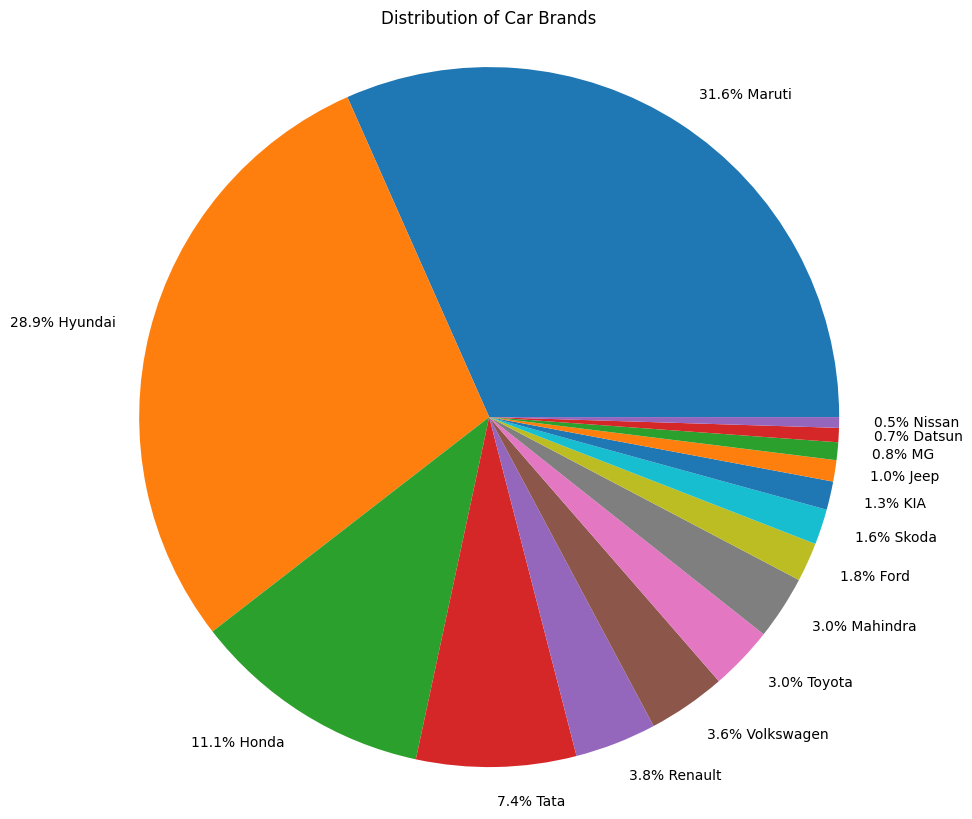

In [76]:
brand_counts = df['Brand'].value_counts()

brand_percentages = brand_counts / brand_counts.sum() * 100


labels = [f'{percentage:.1f}% {brand}' for brand, percentage in brand_percentages.items()]

plt.figure(figsize=(12, 10))
plt.pie(brand_counts.values, labels=labels)
plt.title('Distribution of Car Brands')
plt.axis('equal')  


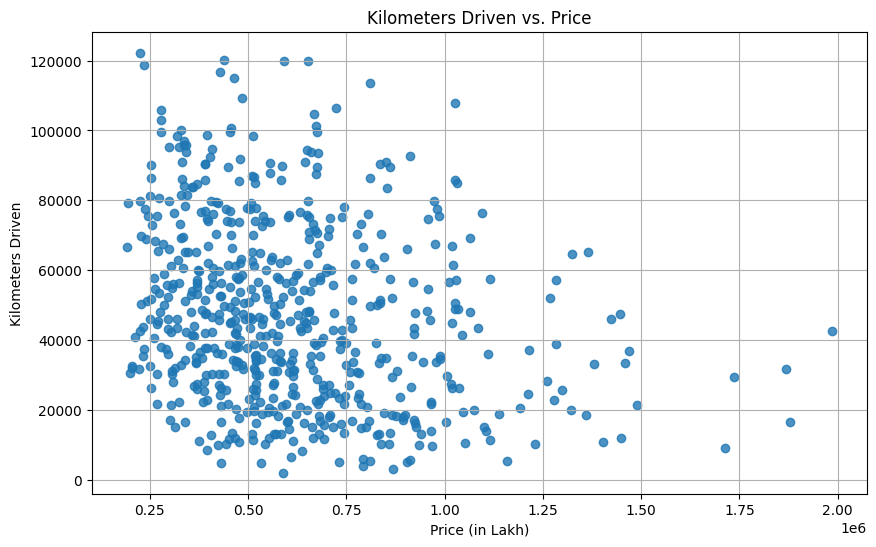

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Price'],df['KilometersDriven'], alpha=0.8)
plt.title('Kilometers Driven vs. Price')
plt.ylabel('Kilometers Driven')
plt.xlabel('Price (in Lakh)')
plt.grid(True)
plt.show()

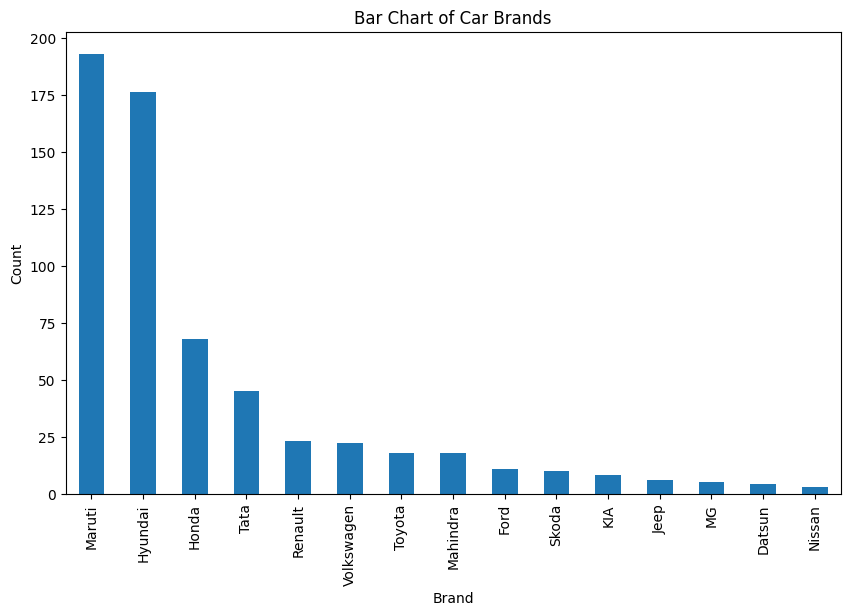

In [78]:
# Bar Chart of Car Brands
plt.figure(figsize=(10, 6))
df['Brand'].value_counts().plot(kind='bar')
plt.title('Bar Chart of Car Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()


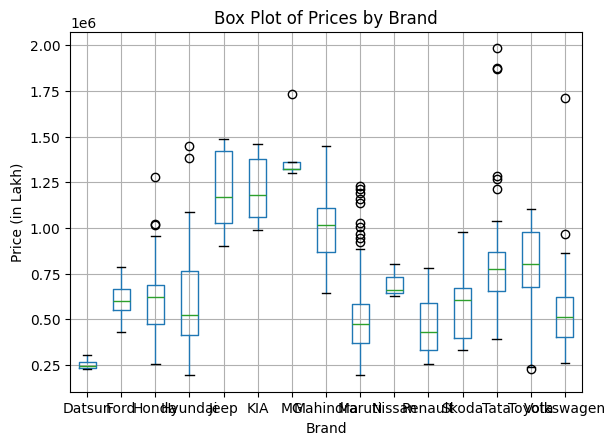

In [79]:

df.boxplot(column='Price', by='Brand')
plt.title('Box Plot of Prices by Brand')
plt.suptitle('')  # Suppress the default title to keep the plot clean
plt.xlabel('Brand')
plt.ylabel('Price (in Lakh)')
plt.show()


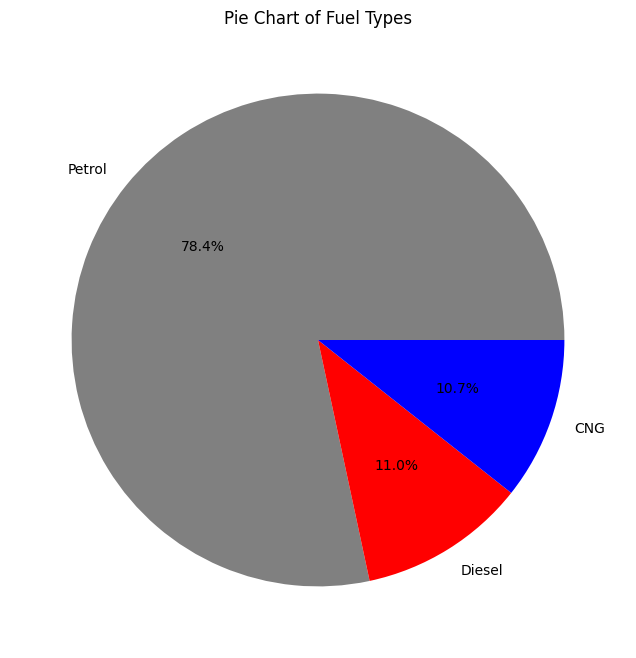

In [80]:
# Pie Chart of Fuel Types
plt.figure(figsize=(8, 8))
df['FuelType'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = ["gray","red","blue"])
plt.title('Pie Chart of Fuel Types')
plt.ylabel('')
plt.show()


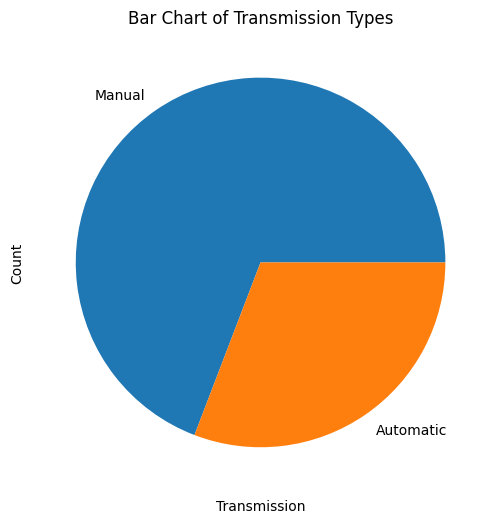

In [81]:
# Bar Chart of Transmission Types
plt.figure(figsize=(10, 6))
df['Transmission'].value_counts().plot(kind='pie')
plt.title('Bar Chart of Transmission Types')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.show()


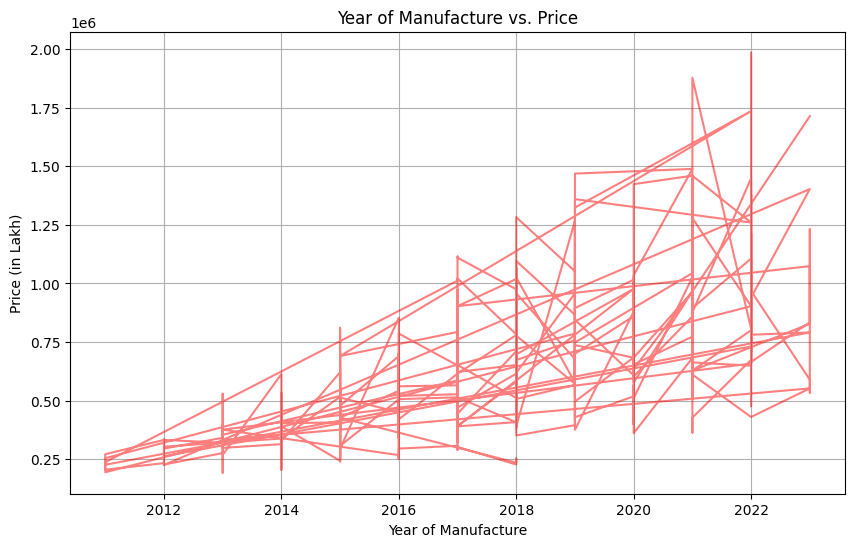

In [82]:
# Scatter Plot of Year of Manufacture vs. Price
plt.figure(figsize=(10, 6))
plt.plot(df['YearofManufacture'], df['Price'], c='red', alpha=0.5)
plt.title('Year of Manufacture vs. Price')
plt.xlabel('Year of Manufacture')
plt.ylabel('Price (in Lakh)')
plt.grid(True)



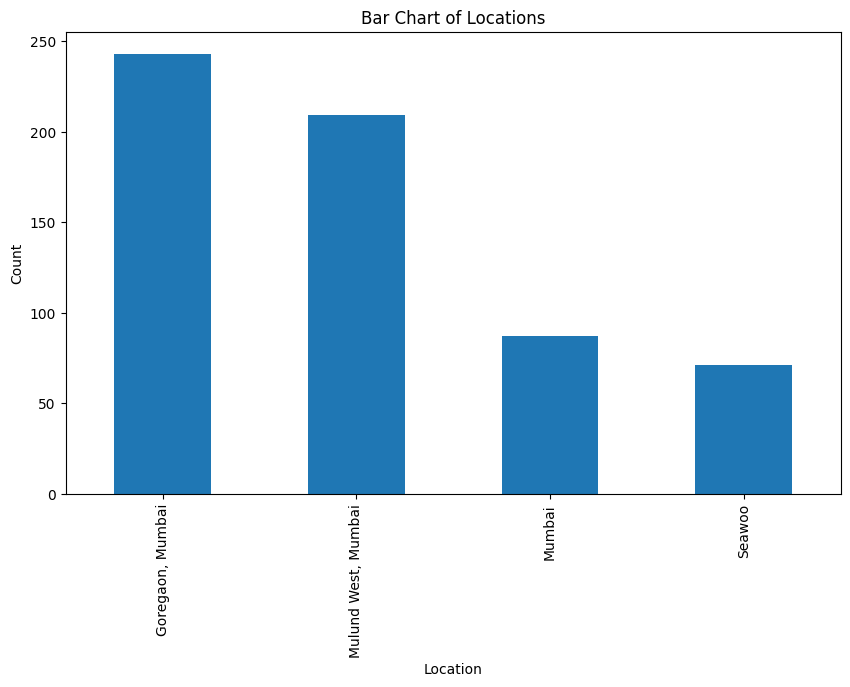

In [83]:
# Bar Chart of Locations
plt.figure(figsize=(10, 6))
df['Location'].value_counts().plot(kind='bar')
plt.title('Bar Chart of Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()


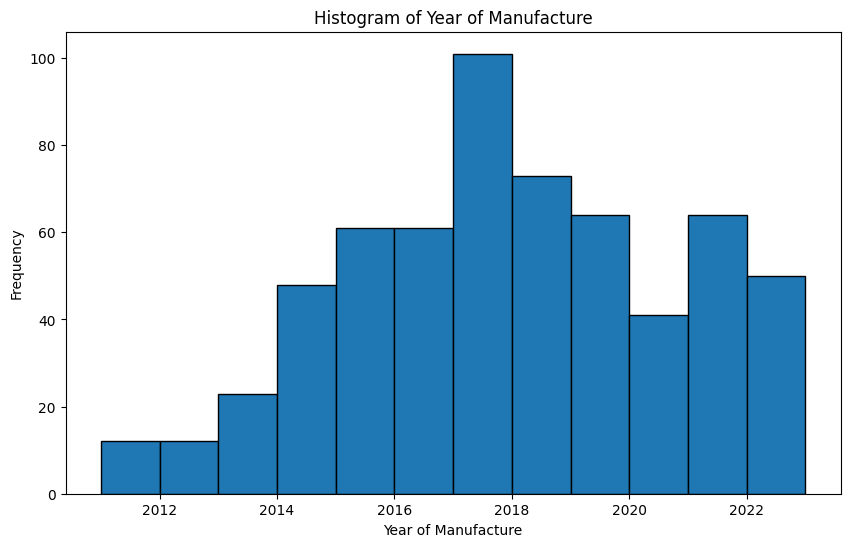

In [84]:
plt.figure(figsize=(10, 6))
plt.hist(df['YearofManufacture'], bins=range(df['YearofManufacture'].min(), df['YearofManufacture'].max() + 1), edgecolor='black')
plt.title('Histogram of Year of Manufacture')
plt.xlabel('Year of Manufacture')
plt.ylabel('Frequency')
plt.show()

In [85]:
df.to_csv('cars24.csv', index=False)